## Why convolutions are effective

Convolutional neural networks have seen great success in computer vision tasks. However, why is this architecture so effective? This article hopes to elucidate the apparent efficacy of convolutional networks in many computer vision tasks. We'll approach this by training a convolutional network on the Fashion MNIST dataset.

### A brief look at the dataset

First, we make some necessary imports:

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary

device_name = None
if torch.cuda.is_available():
    device_name = 'cuda'
else:
    device_name = 'cpu'
device = torch.device(device_name)
print('Using device: ' + device_name)

Using device: cuda


Then, we load the dataset and display it:

In [3]:
# this will download the dataset to a local directory if not downloaded already
# otherwise looks for a directory named "fashion_mnist"
train_dataset = torchvision.datasets.FashionMNIST(root='fashion_mnist', download=True, train=True, transform=ToTensor())
test_dataset = torchvision.datasets.FashionMNIST(root='fashion_mnist', download=True, train=False, transform=ToTensor())

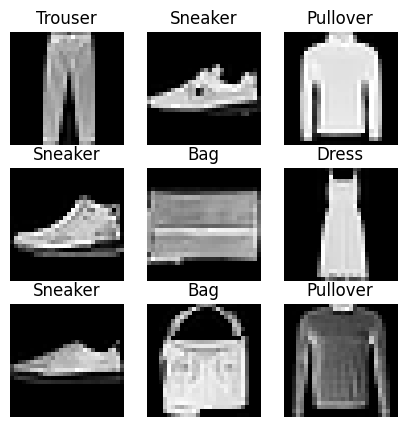

In [4]:
labels = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle Boot'
]
figure = plt.figure(figsize=(5, 5))
rows, cols = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

The FashionMNIST dataset has 9 classes (indicated in the `labels` array above) and they each consist of $28 \times 28$ grayscale images. Unlike RGB, this means that each pixel has only one value. We can verify this by looking at an example from the dataset:

In [ ]:
sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
img, _ = train_dataset[sample_idx]
print(f'Image shape: {img.shape}')
max_pixel_val = torch.max(img)
min_pixel_val = torch.min(img)
print(f'Range of image pixels: {min_pixel_val} to {max_pixel_val}')

### What are convolutions?

The convolution operation is defined as below:

$$C(j, k) = \sum_{l} \sum_{m} I(j + l, k + m) K(l, m)$$

where $I$ is an image and $K$ is called the *kernel*. The above equation gives the computation for the $j, k$ entry of $C$. In this case, $K$ is a learnable parameter. The resulting $C$ is called a feature map. Though the above is called a convolution in machine learning literature, it is actually called the "[cross correlation](https://en.wikipedia.org/wiki/Cross-correlation)" operation, which comes from signal processing and statistics. The main reason we use convolutional layers is because they retain "inductive bias", i.e, they are able to exploit the properties of images better than a typical multilayer-perception network. In particular, convolutions maintain *equivariance*, which essentially means that if an input image is transformed and passed through a convolutional layer, the feature map will be transformed in a consistent manner. In our image classification example, we seek a special case of equivariance, namely, *invariance*, whereby a translation, rotation, or scaling of the input image will not affect its classification. We will implement the convolution operation as well as some additional features to demonstrate how it works.

### Creating a convolutional neural network

#### Basic implementation

We implement a custom convolution layer. Note that the layer we are creating is not trainable (which I've done to make the implementation of convolution a bit easier to understand), but it doesn't take too much effort to make the `DIYConv2D` layer usable. 
In addition to the this convolution layer, I've also created a `test_conv_impl` to compare our convolutional layer with the one created by Pytorch. The code below implements the convolution (cross-correlation) operation that we discussed above:

In [ ]:
class DIYConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding='valid', stride=1):
        # TODO: implement padding and stride
        super().__init__()
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.kernel = torch.rand(out_channels, in_channels, kernel_size, kernel_size)
        self.bias = torch.rand(out_channels,)

    # For testing
    def _set_parameters(self, kernel, bias):
        self.kernel = kernel
        self.bias = bias
        assert self.kernel.shape == (self.out_channels, self.in_channels, self.kernel_size, self.kernel_size)
        assert self.bias.shape == (self.out_channels,)
    
    def forward(self, x):
        height = x.shape[1] - self.kernel_size + 1
        width = x.shape[2] - self.kernel_size + 1
        conv = torch.zeros((self.out_channels, height, width))
        for i in range(self.out_channels):
            for j in range(height):
                for k in range(width):
                    conv[i][j][k] = torch.sum(self.kernel[i, ...] * x[..., j:j+self.kernel_size, k:k+self.kernel_size])
        return conv + self.bias.reshape(self.out_channels, 1, 1)

def test_conv_impl(img_width, img_height, kernel_size, padding=0, stride=1):
    img = torch.rand(1, img_width, img_height)
    conv_layer = nn.Conv2d(kernel_size=kernel_size, in_channels=1, out_channels=3, stride=stride, padding=padding, dilation=1, bias=True)
    diy_conv_layer = DIYConv2D(1, 3, kernel_size=kernel_size, padding=padding, stride=stride)
    diy_conv_layer._set_parameters(conv_layer.weight, conv_layer.bias)
    conv_layer_output = conv_layer(img)
    diy_conv_layer_output = diy_conv_layer(img)
    print(conv_layer_output)
    print(diy_conv_layer_output)
    assert torch.allclose(conv_layer_output, diy_conv_layer_output, atol=1e-5, rtol=1e-5)

test_conv_impl(3, 3, 2)
test_conv_impl(28, 28, 3)
test_conv_impl(32, 64, 8)

#### Padding

One problem with the convolution operation is that pixels near the edge of the image are not convolved. We can solve this problem by adding *padding* to the image. Another reason to use padding is to ensure that the dimensions of the feature map match the dimensions of the input. Consider the following $3 \times 3$ image:

$\begin{bmatrix} 1 & 2 & 3 \\ 4 & 5 & 6 \\ 7 & 8 & 9 \end{bmatrix}$

And say we apply one layer of padding. Then, the image becomes: 

$\begin{bmatrix} 0 & 0 & 0 & 0 & 0 \\ 0 & 1 & 2 & 3 & 0 \\ 0 & 4 & 5 & 6 & 0 \\ 0 & 7 & 8 & 9 & 0 \\  0 & 0 & 0 & 0 & 0 \end{bmatrix}$

If we were to now apply a $2 \times 2$ kernel, we would be able to convolve the corners and edges of the image. In general, if we add $P$ pixels on each side of a $J \times K$ image and convolve it with a $M \times M$ kernel, then the dimension of the feature map is $(J + 2P - M + 1) \times (K + 2P - M + 1)$. When $P = 0$, we say the feature map has "valid" padding and when $P$ is selected to make the feature map have the same dimensions as the input, we say it has "same" padding. For odd $M$, we can select $P = \frac{M-1}{2}$. Then, the $(J + 2P - M + 1) \times (K + 2P - M + 1)$ image will be $J \times K$ in size, the same as the original image.

> Note: Adding padding to images for even-sized kernels is not necessarily well-defined. It seems that Pytorch will do this by adding padding to the right and bottom of the matrix as described [here](https://github.com/pytorch/pytorch/issues/3867). Generally for computer vision tasks, we use odd-sized kernels so that the padding is symmetric on all sides and there is a well-defined central pixel (see the textbook by Bishop in the References below for more details).

In [ ]:
class DIYConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding='valid', stride=1):
        super().__init__()
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.kernel = torch.rand(out_channels, in_channels, kernel_size, kernel_size)
        self.bias = torch.rand(out_channels,)
        self.padding = padding

    # For testing
    def _set_parameters(self, kernel, bias):
        self.kernel = kernel
        self.bias = bias
        assert self.kernel.shape == (self.out_channels, self.in_channels, self.kernel_size, self.kernel_size)
        assert self.bias.shape == (self.out_channels,)

    def _add_padding(self, x):
        padding = None
        if self.padding == 'valid':
            padding = 0
        elif self.padding == 'same':
            padding = (self.kernel_size - 1) // 2
        elif isinstance(self.padding, int):
            padding = self.padding
        else:
            raise Exception(f'Undefined padding mode \"{self.padding}\"')
        padded_x = x
        for _ in range(padding):
            padding_vertical = torch.zeros((padded_x.shape[0], padded_x.shape[1] + 2, 1))
            padding_horizontal = torch.zeros((padded_x.shape[0], 1, padded_x.shape[2]))
            padded_x = torch.cat((padding_horizontal, padded_x, padding_horizontal), dim=1)
            padded_x = torch.cat((padding_vertical, padded_x, padding_vertical), dim=2)
        return padded_x
    
    def forward(self, x):
        x = self._add_padding(x)
        height = x.shape[1] - self.kernel_size + 1
        width = x.shape[2] - self.kernel_size + 1
        conv = torch.zeros((self.out_channels, height, width))
        for i in range(self.out_channels):
            for j in range(height):
                for k in range(width):
                    conv[i][j][k] = torch.sum(self.kernel[i, ...] * x[..., j:j+self.kernel_size, k:k+self.kernel_size])
        return conv + self.bias.reshape(self.out_channels, 1, 1)

test_conv_impl(3, 3, 3, padding='valid')
test_conv_impl(3, 3, 3, padding='same')
test_conv_impl(3, 3, 1, padding=2)
test_conv_impl(28, 28, 5, padding='valid')
test_conv_impl(28, 28, 5, padding='same')
test_conv_impl(28, 28, 5, padding=2)
test_conv_impl(32, 64, 7, padding='valid')
test_conv_impl(32, 64, 7, padding='same')
test_conv_impl(32, 64, 7, padding=10)

#### Stride

Sometimes, instead of padding, we wish to make the feature map smaller than the input rather than keep it of a similar size. We can do this by using a different *stride* when applying the kernel. Essentially, instead of moving the sliding window over by $1$ each time, we skip $S$ pixels. The resulting feature map has the size $(\lfloor \frac{J + 2P - M}{S} + 1 \rfloor) \times (\lfloor \frac{K + 2P - M}{S} + 1 \rfloor)$. The code below is not too different from the above; we just skip $S$ pixels in the loop.

In [ ]:
class DIYConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding='valid', stride=1):
        super().__init__()
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.kernel = torch.rand(out_channels, in_channels, kernel_size, kernel_size)
        self.bias = torch.rand(out_channels)
        self.padding = padding
        self.stride = stride

    # For testing
    def _set_parameters(self, kernel, bias):
        self.kernel = kernel
        self.bias = bias
        assert self.kernel.shape == (self.out_channels, self.in_channels, self.kernel_size, self.kernel_size)
        assert self.bias.shape == (self.out_channels,)

    def _add_padding(self, x):
        padding = None
        if self.padding == 'valid':
            padding = 0
        elif self.padding == 'same':
            padding = (self.kernel_size - 1) // 2
        elif isinstance(self.padding, int):
            padding = self.padding
        else:
            raise Exception(f'Undefined padding mode \"{self.padding}\"')
        padded_x = x
        for _ in range(padding):
            padding_vertical = torch.zeros((padded_x.shape[0], padded_x.shape[1] + 2, 1))
            padding_horizontal = torch.zeros((padded_x.shape[0], 1, padded_x.shape[2]))
            padded_x = torch.cat((padding_horizontal, padded_x, padding_horizontal), dim=1)
            padded_x = torch.cat((padding_vertical, padded_x, padding_vertical), dim=2)
        return padded_x
    
    def forward(self, x):
        x = self._add_padding(x)
        height = int(np.floor(1 + (x.shape[1] - self.kernel_size) / self.stride))
        width = int(np.floor(1 + (x.shape[2] - self.kernel_size) / self.stride))
        conv = torch.zeros((self.out_channels, height, width))
        jc, kc = 0, 0
        for i in range(self.out_channels):
            jc = 0
            for j in range(0, x.shape[1] - self.kernel_size + 1, self.stride):
                kc = 0
                for k in range(0, x.shape[2] - self.kernel_size + 1, self.stride):
                    conv[i][jc][kc] = torch.sum(self.kernel[i, ...] * x[..., j:j+self.kernel_size, k:k+self.kernel_size])
                    kc += 1
                jc += 1
        return conv + self.bias.reshape(self.out_channels, 1, 1)

test_conv_impl(3, 3, 3, padding='valid')
test_conv_impl(3, 3, 3, padding='same')
test_conv_impl(3, 3, 1, padding=2)
test_conv_impl(28, 28, 5, padding='valid', stride=2)
test_conv_impl(28, 28, 5, padding='same')
test_conv_impl(28, 28, 5, padding=2, stride=3)
test_conv_impl(32, 64, 7, padding='valid', stride=2)
test_conv_impl(32, 64, 7, padding='same')
test_conv_impl(32, 64, 7, padding=10, stride=4)

#### Pooling

This next aspect is separate from the convolution operation we have been writing. *Pooling* is essentially the convolution operation except instead of multiplying and summing with a kernel, we apply some other function. The two most common types of pooling are average pooling and max pooling. To illustrate what pooling is, we perform a $2 \times 2$ max pool operation on the following $3 \times 3$ matrix:

$\begin{bmatrix} 1 & 2 & 3 \\ 4 & 5 & 6 \\ 7 & 8 & 9 \end{bmatrix}$

The pooling operation is still like a sliding window, so we look at the first $2 \times 2$ submatrix:

$\begin{bmatrix} 1 & 2 \\ 4 & 5 \end{bmatrix}$

and we take the maximum of all these elements, which is $5$. We then slide the window over and take the maximum of the next $2 \times 2$ submatrix:

$\begin{bmatrix} 2 & 3 \\ 5 & 6 \end{bmatrix}$

which is $6$. Continuing this way, we arrive at the following max-pooled matrix:

\begin{bmatrix} 5 & 6 \\ 8 & 9 \end{bmatrix}

If we were to use average pooling, we would take the average of each window and use that as the entries to get the following matrix:

\begin{bmatrix} 3 & 4 \\ 6 & 7 \end{bmatrix}

The primary use of the pooling operation is to allow for *invariance*. For example, in the case of the FashionMNIST dataset, we would like our neural network to be invariant to translations and rotations of the images, i.e, it should be able to tell that a T-shirt is a T-shirt regardless of whether the image is upside-down or rightside-up. 

#### Training and Evaluation

Now all that's left to do is train the network. The network below is a modified version of the LeNet5 network implemented in this Pytorch tutorial. It embodies many of the principles that we discussed above for a convolutional network. It uses max-pooling to be invariant to transformations and increases the number of filters to magnify the receptive field of earlier layers. 
The convolution-ReLU-maxpool trend is typical for most convolutional neural networks.

In [ ]:
class FashionClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        

In [ ]:
batch_size = 32
classifier = FashionClassifier()
classifier.train(True)
summary(classifier, input_size=(batch_size, 1, 28, 28))

Since this is an image classification task, we use cross-entropy loss:

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.001, momentum=0.9)

In [ ]:
epochs = 10
for epoch in range(epochs):
    print(f'Epoch {epoch+1}:')
    total_epoch_loss = 0
    i = 0
    for input, target in DataLoader(train_dataset, batch_size=batch_size, shuffle=True):
        x = input.cuda()
        y = target.cuda()
        optimizer.zero_grad()
        yhat = classifier(x)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        total_epoch_loss += loss.item()
        # 1875 / 375 = 5, so 5 reports per epoch
        if i % 375 == 374:
            print(f' batch {i+1} loss: {total_epoch_loss / 1000}')
            total_epoch_loss = 0
        i += 1

In [ ]:
accuracy = 0.
with torch.no_grad():
    for i, data in enumerate(test_dataset):
        x, y = data
        yhat = classifier(x.cuda())
        accuracy += torch.argmax(yhat) == y
accuracy / len(test_dataset)

If you run this in the notebook, then you should get roughly 85% accuracy on the dataset, which is not bad for a small network. Though this article explored convolutions for a simple image classification task, the convolution operation can be used for object detection, face recognition, and non-computer-vision tasks, such as audio/speech processing (in this case, the convolution would be one dimensional). Either way, the main reason to use convolutions in a network boils down to 1) parameter sharing, 2) sparse connections, and 3) for inference on images of different sizes without retraining.

### References

* Modified LeNet5 network: https://pytorch.org/tutorials/beginner/introyt/trainingyt.html
* Pytorch tutorial for basic neural network training: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
* FashionMNIST dataset: https://github.com/zalandoresearch/fashion-mnist
* Issue discussing padding for even-sized kernels: https://github.com/pytorch/pytorch/issues/3867
* Deep Learning: Foundations and Concepts: https://www.bishopbook.com/
* Cross Correlation operation: https://en.wikipedia.org/wiki/Cross-correlation